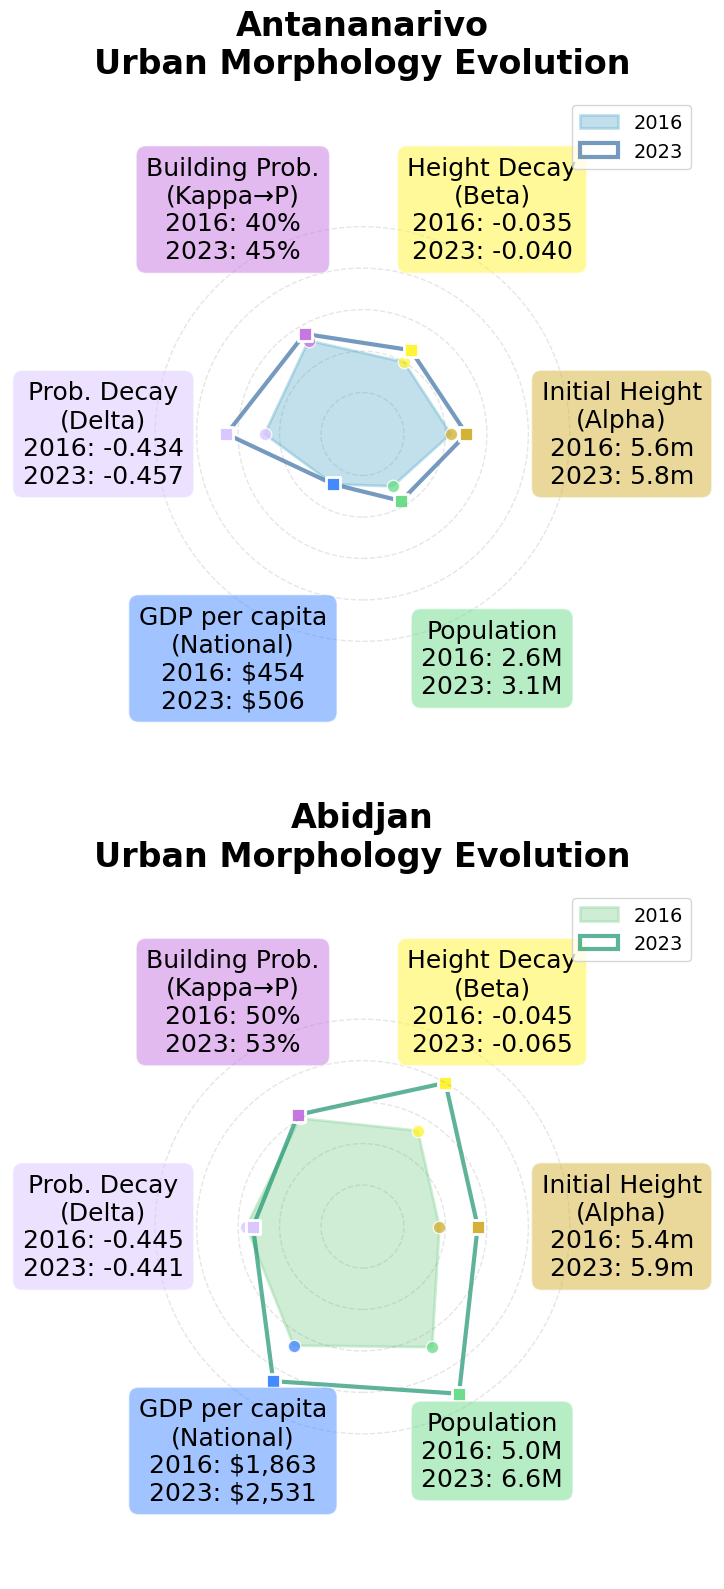

Kappa to Probability Conversion:
Antananarivo 2016: kappa=-0.40 → P=0.400
Antananarivo 2023: kappa=-0.21 → P=0.447
Abidjan 2016: kappa=0.01 → P=0.503
Abidjan 2023: kappa=0.11 → P=0.528


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

class CityComparisonRoseChart:
    def __init__(self, figsize=(8, 16)):
        self.figsize = figsize
        self.labels = ['Initial Height\n(Alpha)', 'Height Decay\n(Beta)', 'Building Prob.\n(Kappa→P)', 'Prob. Decay\n(Delta)', 'GDP per capita\n(National)','Population']
        self.explanations = ['Avg height at center', 'Height decline rate', 'Center building prob.', 'Prob. decline rate', 'National GDP/capita','City population']
        
        # 颜色分组：alpha/beta用黄色系，delta/kappa用紫色系
        self.dimension_colors = {
            'population': '#6fdc8c',
            'alpha': '#d4b237', 
            'beta': '#fff537', 
            'kappa': '#c677e2',  
            'delta': '#dbc7ff',
            'gdp_per_capita': '#4589ff'
        }
        
        # 城市年份颜色
        self.city_colors = {
            'Antananarivo_2016': '#64B2CD',  # 浅蓝色
            'Antananarivo_2023': '#3C70A4',  # 深蓝色
            'Abidjan_2016': '#88D498',       # 浅绿色
            'Abidjan_2023': '#1A936F'        # 深绿色
        }
        
    def kappa_to_probability(self, kappa):
        """
        将kappa (log-odds) 转换为概率P
        P = exp(kappa) / (1 + exp(kappa))
        """
        return np.exp(kappa) / (1 + np.exp(kappa))
        
    def normalize_data(self, data):
        """
        标准化数据到0-1范围，根据实际数据范围调整
        """
        norm_data = {}
        
        # Population (线性标准化，范围2-7 million)
        if 'population' in data:
            pop_normalized = (data['population'] - 2) / 5  # 范围2-7M
            norm_data['population'] = max(0.1, min(1, pop_normalized))
            
        # GDP per capita (线性标准化，范围300-3000)
        if 'gdp_per_capita' in data:
            gdp_normalized = (data['gdp_per_capita'] - 300) / 2700  # 范围300-3000
            norm_data['gdp_per_capita'] = max(0.1, min(1, gdp_normalized))
            
        # Alpha (城市中心初始高度，范围5-7m)
        if 'alpha' in data:
            alpha_normalized = (data['alpha'] - 5) / 2  # 范围5-7m
            norm_data['alpha'] = max(0.1, min(1, alpha_normalized))
            
        # Beta (高度衰减斜率，范围-0.02到-0.08)
        if 'beta' in data:
            beta_normalized = (abs(data['beta']) - 0.02) / 0.06  # 范围0.02-0.08
            norm_data['beta'] = max(0.1, min(1, beta_normalized))
            
        # Kappa (转换为概率)
        if 'kappa' in data:
            probability = self.kappa_to_probability(data['kappa'])
            norm_data['kappa'] = probability  # 概率本身就是0-1
            
        # Delta (概率衰减斜率，范围-0.4到-0.5)
        if 'delta' in data:
            delta_normalized = (abs(data['delta']) - 0.4) / 0.1  # 范围0.4-0.5
            norm_data['delta'] = max(0.1, min(1, delta_normalized))
            
        return norm_data
    
    def format_original_value(self, key, value):
        """
        格式化原始数值显示
        """
        if key == 'population':
            return f"{value:.1f}M"
        elif key == 'gdp_per_capita':
            return f"${value:,.0f}"
        elif key == 'alpha':
            return f"{value:.1f}m"
        elif key == 'beta':
            return f"{value:.3f}"
        elif key == 'kappa':
            prob = self.kappa_to_probability(value)*100
            return f"{prob:.0f}%"
        elif key == 'delta':
            return f"{value:.3f}"
        else:
            return f"{value:.3f}"
    
    def create_hexagon_coordinates(self, center, radius, values):
        """
        创建六边形坐标，增强变化可见性
        """
        angles = np.linspace(0, 2*np.pi, 7)  # 7个点，最后一个与第一个相同形成闭合
        coordinates = []
        
        for i in range(6):
            # 根据数值调整半径，增大变化幅度
            adjusted_radius = radius * (0.2 + 0.8 * values[i])  # 最小半径为0.2*radius，增大变化范围
            x = center[0] + adjusted_radius * np.cos(angles[i])
            y = center[1] + adjusted_radius * np.sin(angles[i])
            coordinates.append([x, y])
            
        coordinates.append(coordinates[0])  # 闭合多边形
        return np.array(coordinates)
    
    def plot_city_comparison(self, antananarivo_2016, antananarivo_2023, 
                           abidjan_2016, abidjan_2023):
        """
        绘制两个城市的对比图
        """
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=self.figsize)
        
        # 绘制Antananarivo
        self.plot_city_evolution(antananarivo_2016, antananarivo_2023, 
                               "Antananarivo", ax1, 
                               colors_2016='#64B2CD', colors_2023='#3C70A4')
        
        # 绘制Abidjan
        self.plot_city_evolution(abidjan_2016, abidjan_2023, 
                               "Abidjan", ax2,
                               colors_2016='#88D498', colors_2023='#1A936F')
        
        plt.tight_layout()
        return fig
    
    def plot_city_evolution(self, data_2016, data_2023, city_name, ax, 
                          colors_2016, colors_2023):
        """
        在单个子图中绘制一个城市的演化
        """
        # 标准化数据
        norm_2016 = self.normalize_data(data_2016)
        norm_2023 = self.normalize_data(data_2023)
        
        original_keys = ['alpha', 'beta', 'kappa', 'delta','gdp_per_capita','population']
        values_2016 = [norm_2016.get(key, 0) for key in original_keys]
        values_2023 = [norm_2023.get(key, 0) for key in original_keys]
        original_2016 = [data_2016.get(key, 0) for key in original_keys]
        original_2023 = [data_2023.get(key, 0) for key in original_keys]
        
        center = (0, 0)
        radius = 1
        
        # 创建两个六边形
        coords_2016 = self.create_hexagon_coordinates(center, radius, values_2016)
        coords_2023 = self.create_hexagon_coordinates(center, radius, values_2023)
        
        # 绘制2016年六边形（浅色，填充）
        polygon_2016 = Polygon(coords_2016[:-1], alpha=0.4, facecolor=colors_2016, 
                             edgecolor=colors_2016, linewidth=2, label='2016')
        ax.add_patch(polygon_2016)
        
        # 绘制2023年六边形（深色，仅边框）
        polygon_2023 = Polygon(coords_2023[:-1], alpha=0.7, facecolor='none', 
                             edgecolor=colors_2023, linewidth=3, label='2023')
        ax.add_patch(polygon_2023)
        
        # 绘制顶点和标签
        for i, (label, explanation, orig_key) in enumerate(zip(self.labels, self.explanations, original_keys)):
            # 使用维度特定颜色绘制顶点
            point_color = self.dimension_colors.get(orig_key, '#666666')
            
            # 2016年顶点
            ax.scatter(coords_2016[i][0], coords_2016[i][1], 
                      c=point_color, s=80, alpha=0.8, edgecolor='white', linewidth=1,
                      marker='o')
            
            # 2023年顶点
            ax.scatter(coords_2023[i][0], coords_2023[i][1], 
                      c=point_color, s=100, alpha=1.0, edgecolor='white', linewidth=2,
                      marker='s')  # 方形标记区分年份
            
            # 添加标签和数值
            label_offset = 1.25
            label_x = center[0] + label_offset * np.cos(2*np.pi*i/6)
            label_y = center[1] + label_offset * np.sin(2*np.pi*i/6)
            
            # 格式化数值
            value_2016 = self.format_original_value(orig_key, original_2016[i])
            value_2023 = self.format_original_value(orig_key, original_2023[i])
            
            # 特殊处理kappa显示概率
            if orig_key == 'kappa':
                display_text = f'{label}\n2016: {value_2016}\n2023: {value_2023}'
            else:
                display_text = f'{label}\n2016: {value_2016}\n2023: {value_2023}'
            
            ax.text(label_x, label_y, display_text, 
                   ha='center', va='center', fontsize=18, color = 'black',
                   bbox=dict(boxstyle='round,pad=0.4', facecolor=point_color,
                            alpha=0.5, edgecolor='white'))
        
        # 绘制参考圆
        for r in [0.2, 0.4, 0.6, 0.8, 1.0]:
            circle = plt.Circle(center, r, fill=False, color='gray', alpha=0.2, linestyle='--')
            ax.add_patch(circle)
        
        # 设置坐标轴
        ax.set_xlim(-1.7, 1.7)
        ax.set_ylim(-1.7, 1.7)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.set_aspect('equal')
        # ax.grid(True, alpha=0.2)
        ax.set_title(f'{city_name}\nUrban Morphology Evolution', fontsize=24, fontweight='bold')
        
        # 添加图例
        ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98), fontsize=14)
        
        # 添加说明文字
        # legend_text = ("○ 2016 data points\n"
        #               "□ 2023 data points\n"
        #               "Filled area: 2016 coverage\n"
        #               "Outline: 2023 coverage")
        # ax.text(-1.6, -1.4, legend_text, fontsize=14, 
        #        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))

# 使用示例
if __name__ == "__main__":
    # Antananarivo数据
    antananarivo_2016 = {
        'population': 2.57,     # 2.57 million
        'alpha': 5.565,          # 城市中心初始平均高度 (meters)
        'beta': -0.035,          # 高度随remoteness下降斜率
        'kappa': -0.404,           # log-odds of building existence at center
        'delta': -0.434,         # 建筑概率随remoteness下降斜率
        'gdp_per_capita': 453.97 # Madagascar国家GDP per capita
    }
    
    antananarivo_2023 = {
        'population': 3.08,     # 3.08 million
        'alpha': 5.754,          # 城市中心初始平均高度 (meters)
        'beta': -0.040,          # 高度随remoteness下降斜率
        'kappa': -0.212,          # log-odds of building existence at center
        'delta': -0.457,          # 建筑概率随remoteness下降斜率
        'gdp_per_capita': 506.16 # Madagascar国家GDP per capita
    }
    
    # Abidjan数据
    abidjan_2016 = {
        'population': 4.95,     # 4.95 million
        'alpha': 5.428,          # 城市中心初始平均高度 (meters)
        'beta': -0.045,          # 高度随remoteness下降斜率
        'kappa': 0.014,           # log-odds of building existence at center
        'delta': -0.445,         # 建筑概率随remoteness下降斜率
        'gdp_per_capita': 1862.6 # Côte d'Ivoire国家GDP per capita
    }
    
    abidjan_2023 = {
        'population': 6.57,     # 6.57 million
        'alpha': 5.889,          # 城市中心初始平均高度 (meters)
        'beta': -0.065,          # 高度随remoteness下降斜率
        'kappa': 0.113,           # log-odds of building existence at center
        'delta': -0.441,         # 建筑概率随remoteness下降斜率
        'gdp_per_capita': 2530.85 # Côte d'Ivoire国家GDP per capita
    }
    
    # 创建对比图
    chart = CityComparisonRoseChart()
    fig = chart.plot_city_comparison(antananarivo_2016, antananarivo_2023,
                                   abidjan_2016, abidjan_2023)
    plt.savefig("visualizations/rosemap.png",dpi=300)
    plt.show()
    
    # 打印kappa转换为概率的结果
    print("Kappa to Probability Conversion:")
    print("Antananarivo 2016:", f"kappa={antananarivo_2016['kappa']:.2f} → P={chart.kappa_to_probability(antananarivo_2016['kappa']):.3f}")
    print("Antananarivo 2023:", f"kappa={antananarivo_2023['kappa']:.2f} → P={chart.kappa_to_probability(antananarivo_2023['kappa']):.3f}")
    print("Abidjan 2016:", f"kappa={abidjan_2016['kappa']:.2f} → P={chart.kappa_to_probability(abidjan_2016['kappa']):.3f}")
    print("Abidjan 2023:", f"kappa={abidjan_2023['kappa']:.2f} → P={chart.kappa_to_probability(abidjan_2023['kappa']):.3f}")